# Deep Learning for Text Analytics: Assignment 3

### Timur Tenishev, August 2024

In [331]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import urllib.request

# For natural language preprocessing
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# For model development
import pysentiment2 as ps
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# 1. Data Exploration

In [73]:
train_data = pd.read_parquet("btc_tweets_train.parquet.gzip")
test_data = pd.read_parquet("btc_tweets_test.parquet.gzip")

In [74]:
print(train_data.shape)
print(test_data.shape)

train_data.head()

(1500, 5)
(500, 5)


,hashtags,content,username,user_displayname,sentiment
tweet ID,,,,,
1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,True
1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,True
1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,True
1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,True


In [75]:
test_data.head()

,hashtags,content,username,user_displayname,sentiment
tweet ID,,,,,
1641861708246552576,"[crypto, btc]",#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,花花研究院 | Crypto Alpha🇨🇳,True
1641861783898972167,"[Bitcoin, Bitcoin]",#Bitcoin would have to fall another 80% to rea...,luke_broyles,Luke Broyles,False
1641862152532418562,"[Giveaway, BTC, SolanaGiveaways, Giveaway, Air...",#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,Crypto Mars,True
1641862338369183753,"[EOS, USDT, BTC, crypto, Bitcoin, etherium, Bi...",Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,Andrey Ukraine,True
1641862430434131968,"[BTC, ETH, BSC, GroveToken]",Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,Justin Anderson,True


In [76]:
train_data.query("sentiment == True").head().content.to_list()

['$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏\n\n#Bitcoin\xa0TO $100,000 WHETHER YOU BELIEVE OR NOT‼️💯🙏\n\n$BTC #Bitcoin\xa0#BTC\xa0\xa0\xa0\n\n#Bitcoin\xa0#BTC\xa0#SHIB \n#HOGE #SAITAMA #BNB\xa0\xa0\xa0#DOGE #ETH #BabyFloki #AltCoinSeason https://t.co/rtlFlKlVCv',
 'Alright I have my rares. Who else is grabbing some of these @DogePunksBTC? Been in the discord a bit today and lovin the vibes. #Bitcoin #bitcoinordinals #crypto https://t.co/oaSNb6zOfK',
 'Bitcoin (BTC) Targets Over $100,000 as This Important Pattern Reemerges, Analyst Says\n\n$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏\n\n#BTC TO $100,000 WHETHER YOU BELIEVE OR NOT‼️💯🙏\n\n#SHIB \n#HOGE #SAITAMA #BNB\xa0\xa0\xa0#DOGE #ETH #BabyFloki #AltCoinSeason  https://t.co/gU71C732NS',
 '📢 Xverse Web-based pool is live:\n\n•Update @xverseApp Chrome Browser Extension wallet to V0.6.2\n\n•Stack @Stacks 👇\n\n https://t.co/s17rWwKnPD\n\n•Earn #BTC Yield\n\n•Continuous Stacking\n\n•Stacking amount Top up at any moment of the cycle h

In [77]:
train_data.query("sentiment == False").head().content.to_list()

['Unpopular opinion:\n\nThis pump isn’t going to stop and we are entering a full fledged bull run.\n\nHOWEVER, there will be a major sell off sometime between April and June next year.\n#Crypto #Bitcoin #Investing https://t.co/4fOMtYvY3c',
 'They want riots. Give them bank runs instead.\n\n#Silver #Gold #Bitcoin \n#IStandWithTrump https://t.co/wBQupqFyuj',
 '$𝟰,𝟭𝟬𝟬,𝟬𝟬𝟬,𝟬𝟬𝟬 worth of #BTC is set to expire tomorrow.\n\nExpect some huge volatility 🚨😱\n\n#Bitcoin #Crypto',
 'Once $BTC gets back to the previous ATH you will start seeing "old friends" and family members who mocked you... coming back to ask you about #Bitcoin as if you were a genius \n#fact',
 'Flip a coin and land tails 78 straight times. \nThat’s about how difficult it is to mine #Bitcoin. \nEvery 10 minutes some machine out there finds a way.\nThat’s putting in the work.']

In [78]:
print(train_data.sentiment.value_counts())
print(test_data.sentiment.value_counts())

True     1220
False     280
Name: sentiment, dtype: int64
True     404
False     96
Name: sentiment, dtype: int64


1. remove escape sequences
2. get rid of punctuation marks and numbers
3. turn everything to lowercase
4. get rid of stopwords
5. analyze the data with wordcloud and word distributions
6. look at the examples of longest and shortest words to see whether its fine or not
7. look at the examples of most and least frequent words to see whether its fine or not
8. include emojis in sentiment analysis - ideas for that are:
    - encode emojis somehow
    - use prestudied sentiment quantities of each emoji as separate features
9. address class imbalance problem (over/undersampling? stratified sampling?)
10. split the train data into train and validation data

employ code from LDA and russian text data analysis. employ measure_time function for convenience.

# 2. Preprocessing

In [293]:
# Take a list of words that are used for splitting of multiword hashtags from the University of Michigan website
vocab_hashtags = []
for word in urllib.request.urlopen('https://websites.umich.edu/~jlawler/wordlist'):
    vocab_hashtags.append(word[:-2].decode('UTF-8'))
vocab_hashtags.extend(['bitcoin', 'blockchain']) # add other relevant words not present in the list

# Make a list of stopwords (i.e. "I", "me", "you", "the", etc.) from English
stop_words = set(stopwords.words('english'))
# Update stopwords with common words like figure, table, references, etc all papers share.
#stop_words.update(['cid', 'et', 'al', 'ef', 'ij', 'aj', 'berlin', 'humboldt', 'university', 'l', 'll', 'lll', 'llll', 'lllll', 'llllll', 'lllllll', 'llllllll', 'lllllllll', 'llllllllll', 'lllllllllll', 'llllllllllll', 'lllllllllllll', 'llllllllllllll', 'lllllllllllllll', 'llllllllllllllll', 'lllllllllllllllll', 'llllllllllllllllll', 'lllllllllllllllllll', 'llllllllllllllllllll', 'acknowledgement', 'abstract', 'introduction' 'conclusions', 'references', 'appendix', 'figure', 'table', 'tables', 'figures'])       
    

def find_word(hashtag, wordlist):
  """Searches for longest possible words contatined in the "beginning" of a hashtag.
  With each iteration the "beginning" of the hashtag is 1 letter shorter"""
  i = len(hashtag) + 1
  while i > 1:
    i -= 1
    if hashtag[:i] in wordlist:
      return hashtag[:i]
  return None

def split_hashtag(hashtag):
  """Splits a hashtag into individual words by capital letters.

  Args:
    hashtag (match object): The hashtag to split.

  Returns:
    string: String of separated words from the hashtag.
  """

  s=hashtag.group(1)
  if s.isupper(): # Do not separate acronym hastags such as #BTC into B T C, instead just return BTC
    return s
  elif s[1:].islower(): # If hashtags are not separable by capital letters, extract the words using the available vocabulary
    s = s.lower() # In case the first letter of a hashtag is capital, e.g. for #Lightningnetwork
    words = []
    word = find_word(s, vocab_hashtags)    
    while word != None and len(s) > 0:
      words.append(word)            
      if len(s) == len(word): # Special case for when eating rest of word
        break
      s = s[len(word):] # delete the found word from the hashtag, search for other words in the rest part of the hashtag
      word = find_word(s, vocab_hashtags)
    return " ".join(words)
  else: # For hashtags separable by capital letters
    return ' '.join(re.split(r'(?=[A-Z])', s)) # Separate #aRandomHastag into a Random Hashtag

def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean(raw_text):
    """Cleans raw text by removing hyperlinks, symbols, multispaces, and short words.

    Args:
        raw_text (str): The raw text to be cleaned.

    Returns:
        str: The cleaned text.
    """

    # Split the hashtags into words
    raw_text = re.sub(r'#(\w+)', split_hashtag, raw_text)

    # Get rid of Twitter usernames
    raw_text = re.sub(r"@[\w]+", " ", raw_text)
    # Combine removal of hyperlinks, newline characters, non-word characters, non-Latin characters, digits
    raw_text = re.sub(r"(http[^ ]*)|[\n\W\d]|[^a-zA-Z]", " ", raw_text)

    # Clean multispaces
    raw_text = re.sub(r"\s{2,}", " ", raw_text)

    # Lower-case, delete stop words and stem words
    words = raw_text.lower().split()
    words = [word for word in words if not word in stop_words] # get rid of stop words
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
    #stemmer = PorterStemmer()
    #stemmed_text = ' '.join([stemmer.stem(word) for word in words])
    # Remove short words (1-2-worders)
    cleaned_text = re.sub(r"\b\w{1,2}\b", " ", lemmatized_text, flags=re.MULTILINE)
    
    # Clean multispaces again
    cleaned_text = re.sub(r"\s{2,}", " ", cleaned_text).strip()

    return cleaned_text

In [294]:
# Apply the cleaning function to the 'content' column and store the cleaned text in a new column 'content_clean'
train_data['content_clean'] = train_data['content'].apply(clean)

# Construct a dataframe for analyzing the results of preprocessing
content_tokenized = [text.split(" ") for text in list(train_data['content_clean'])]
content_tokenized = [word for sublist in content_tokenized for word in sublist]

content_tokenized_df = pd.DataFrame({
    'token': content_tokenized,
    'length': [len(token) for token in content_tokenized]
}).groupby(by=["token", "length"]).size().to_frame('count').reset_index().sort_values(by=['length'])

# Look at the shortest and longest words
content_tokenized_df.head(10).append(content_tokenized_df.tail(10))

In [217]:
re.sub(r'#(\w+)', split_hashtag, "#NLL")

#find_word("Lightningnetwork", vocab_hashtags)

'NLL'

In [289]:
searched_word = "influencemylife"
sentence_index = [searched_word in sublist for sublist in content_tokenized2].index(True)
train_data.iloc[sentence_index]['content']

ValueError: True is not in list

In [228]:
re.sub(r"(http[^ ]*)|[\n\W\d]|[^a-zA-Z]|@[\w]+", " ", train_data.iloc[sentence_index]['content'])

' rxd gem that will last long  BTC  White paper  RXD Community   theartofsatoshi  '

In [307]:
train_data.reset_index()[['content', 'content_clean']].iloc[0]['content']

'$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏\n\n#Bitcoin\xa0TO $100,000 WHETHER YOU BELIEVE OR NOT‼️💯🙏\n\n$BTC #Bitcoin\xa0#BTC\xa0\xa0\xa0\n\n#Bitcoin\xa0#BTC\xa0#SHIB \n#HOGE #SAITAMA #BNB\xa0\xa0\xa0#DOGE #ETH #BabyFloki #AltCoinSeason https://t.co/rtlFlKlVCv'

Text(0, 0.5, 'Amount of Words')

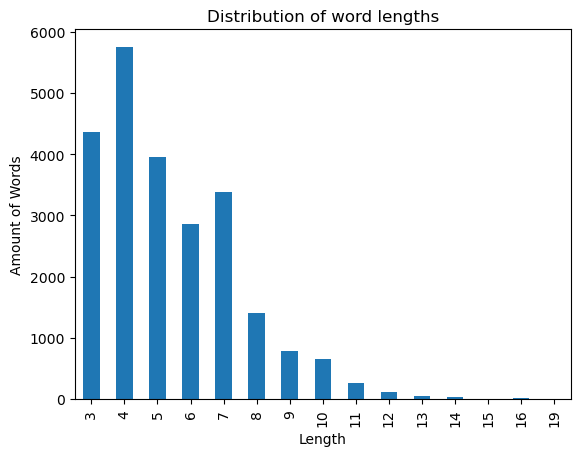

In [296]:
pd.Series([len(token) for token in content_tokenized]).value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of word lengths')
plt.xlabel('Length')
plt.ylabel('Amount of Words')

In [297]:
content_tokenized_df.sort_values('count').tail(10)

,token,length,count
2238,like,4,122
942,currency,8,128
2356,market,6,136
921,crypto,6,137
142,amp,3,185
754,coin,4,191
1339,eth,3,217
920,crypt,5,493
520,btc,3,666
394,bitcoin,7,1249


# 3. Model Training

## 3.1. Sentiment Dictionary

In [324]:
# Apply the sentiment dictionary to the cleaned text
def analyze_sentiment(text):
    hiv4 = ps.HIV4()
    tokens = hiv4.tokenize(text)  # text can be tokenized by other ways
                                  # however, dict in HIV4 is preprocessed
                                  # by the default tokenizer in the library
    score = hiv4.get_score(tokens)
    return score['Positive'] >= score['Negative']

train_data['sentiment_pred_ps'] = train_data['content_clean'].apply(analyze_sentiment)

## 3.2. RNN-based Language Classifier

In [347]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = train_data['content_clean']
y = train_data['sentiment']

# Split the data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Transform the Series to numpy
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Create a vectorization layer
vocab_size=10000
seq_length = 50

vectorize_layer = TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )
vectorize_layer.adapt(X_train)

# Transform sequences of words to seq of integers and labels to tensor
X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

In [353]:
from tensorflow.keras import layers

# Create model with LSTM and bidirectionality
input = tf.keras.Input(shape=(seq_length,), dtype="int64")
emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(rnn_units))(emb)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(input, output)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 32)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6272      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,305
Trainable params: 326,305
Non-trainable params: 0
_____________________________________________________

In [354]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = 2,
    batch_size = 128)

Epoch 1/2
10/10 [==============================] - 16s 307ms/step - loss: 0.6656 - accuracy: 0.7767 - val_loss: 0.6258 - val_accuracy: 0.8133
Epoch 2/2
10/10 [==============================] - 0s 29ms/step - loss: 0.5796 - accuracy: 0.8133 - val_loss: 0.5108 - val_accuracy: 0.8133


## 3.3. DistilBERT Model: Prefine-tuned for Sentiment Analysis

In [387]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\baltt\.huggingface\token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [388]:
from transformers import AutoModelForSequenceClassification
import torch

model_ckpt = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
id2label = {
    True: True,
    False: False
}
label2id = {
    True: True,
    False: False
}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [360]:
len(X_train)

1200

In [389]:
import datasets
from datasets import Dataset, DatasetDict


ImportError: cannot import name 'get_session' from 'huggingface_hub.utils' (c:\Users\baltt\anaconda3\lib\site-packages\huggingface_hub\utils\__init__.py)

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(X_train) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"]
)

## 3.4. DistilBERT model: Fine-tuning on Train Data and Applying on Test Data

# 4. Model Evaluation and Comparison

In [332]:
import tensorflow as tf

# define standarization function 
def our_standardization(text_data):
  remove_non = tf.strings.regex_replace(text_data, '[^a-zA-Z]', ' ') # replace non a-z OR A-Z with " "
  lowercase = tf.strings.lower(remove_non) # convert to lowercase
  pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
  remove_punct = tf.strings.regex_replace(lowercase, pattern_remove_punctuation, '') # apply pattern
  remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
  remove_initial_end_spaces  =tf.strings.regex_replace(remove_double_spaces, '^\s*|\s*$', '')
  return remove_initial_end_spaces

In [333]:
our_standardization("THIS is a test string!!!!!! 34423I love tests :)))")

<tf.Tensor: shape=(), dtype=string, numpy=b'this is a test string i love tests'>

In [341]:
string_to_tensor("THIS is a test string!!!!!! 34423I love tests :)))")

<tf.Tensor: shape=(), dtype=string, numpy=b'THIS is a test string!!!!!! 34423I love tests :)))'>

In [368]:
from datasets import load_dataset

emotions = load_dataset("emotion")

train_ds = emotions["train"]

print(train_ds.features)
print(train_ds[:5])
print(train_ds["text"][:5])

ImportError: cannot import name 'get_session' from 'huggingface_hub.utils' (c:\Users\baltt\anaconda3\lib\site-packages\huggingface_hub\utils\__init__.py)